# Activity 4.5: Gauss-Newton

3 points

**collaboration statement:**

In [1]:
%pip install scipy numpy matplotlib
import numpy as np
from scipy.optimize import minimize
from scipy.sparse import eye, diags
from scipy.sparse import rand as sprand
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
plt.rcParams['figure.figsize'] = [8, 5]

Note: you may need to restart the kernel to use updated packages.


## Nonlinear regression

Suppose we have a nonlinear model of a random process that looks like,

$$d(x) := \exp(C x)\epsilon,$$

where $C\in\mathbb{R}^{m\times n}$, $m \geq n$, is full rank, and $\epsilon$ is a vector of independent, mean-1 random variables.

For example, below $C$ is a collection of randomly chosen locations, $x$ is a scalar, and $\epsilon$ is distributed like the gamma distribution Gamma(1,1).

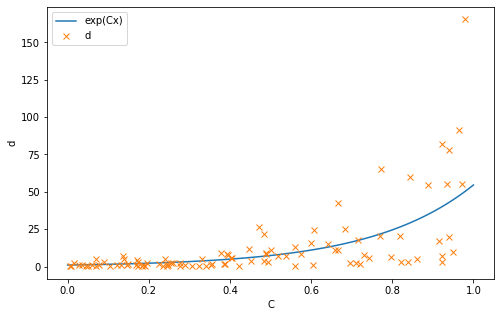

In [2]:
def model_1d(m, n, x):
    C = np.array(sorted(np.random.rand(m)))[:,np.newaxis]
    epsilon = np.random.gamma(1.,1.,size=(m,))
    z = C @ x
    mu = np.exp(z)
    d = mu * epsilon
    return d, C

m = 100
n = 1
Cgrid = np.linspace(0,1,m)[:,np.newaxis]
x = np.array([4.])
d, C = model_1d(m, n, x)
mugrid = np.exp(Cgrid @ x)

ax = plt.figure().gca()
ax.set(xlabel='C', ylabel='d')
ax.plot(Cgrid,mugrid, label="exp(Cx)")
ax.plot(C, d, 'x', label="d")
_ = ax.legend()

Suppose we have $d$ and $C$ but we don't know $\epsilon$ and we would like to estimate $x$.

We could take the logarithm of both sides of the definition of $d$,

$$ \log d - \log \epsilon = C x,$$

ignore the $\log \epsilon$ term, and try to find an estimate $x^*$ with ordinary least-squares,

$$x^* = \arg\min_x \tfrac{1}{2}\|Cx - \log d\|_2^2,$$

which has a linear optimality condition.

But, the result is a biased estimate of $x$.

In [21]:
k = 1000
y = np.random.gamma(1.,1.,k)
print(np.sum(y)/k)
print(np.log(np.sum(y)/k))
print(np.sum(np.log(y))/k)

0.9330742030561034
-0.06927054961870203
-0.6414011569117791


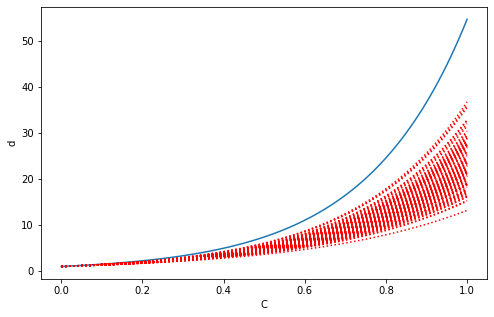

In [3]:
ax = plt.figure().gca()
ax.plot(Cgrid,mugrid)
ax.set(xlabel='C', ylabel='d')
# run the linear estimator 100 times for randomly chosen locations C
for i in range(100):
    d, C = model_1d(m, n, x)
    logd = np.log(d)
    x_est = np.linalg.solve(C.T @ C, C.T @ logd)
    mu_estgrid = np.exp(Cgrid @ x_est)
    ax.plot(Cgrid, mu_estgrid, 'r:')

The problem is that the expectation $E[\log(\epsilon)] < \log(E[\epsilon]) = 0$ due to [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality).

If we know enough about the distribution of $\epsilon$ we could compute $E[\log(\epsilon)]$ and use that to unbias the estimate:

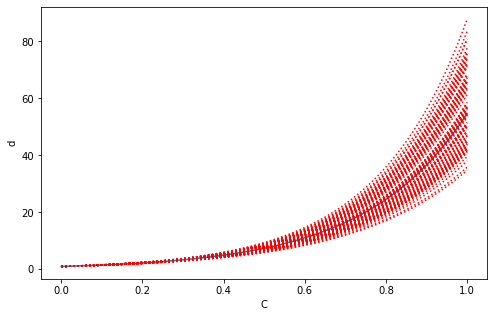

In [4]:
ax = plt.figure().gca()
ax.plot(Cgrid,mugrid)
ax.set(xlabel='C', ylabel='d')
# run the linear estimator 100 times for randomly chosen locations C
for i in range(100):
    d, C = model_1d(m, n, x)
    logd = np.log(d)
    # unbiasing log(d) ............................ here
    x_est = np.linalg.solve(C.T @ C, C.T @ (logd + np.euler_gamma))
    mu_estgrid = np.exp(Cgrid @ x_est)
    ax.plot(Cgrid, mu_estgrid, 'r:')

But if the only thing we're confident that we know about the distribution of $\epsilon$ is that its mean is 1, then we would have to estimate $E[\log(\epsilon)]$ along with $x$.

We can avoid having to know more about $\epsilon$ if we estimate $x^*$ using a _nonlinear least-squares problem_,

$$x^* = \arg\min_x \tfrac{1}{2}\|\exp(Cx) - d\|_2^2 = \tfrac{1}{2}\|\exp(Cx)E[\epsilon] - d\|^2 = \tfrac{1}{2}\|E[\exp(Cx)\epsilon - d]\|^2.$$

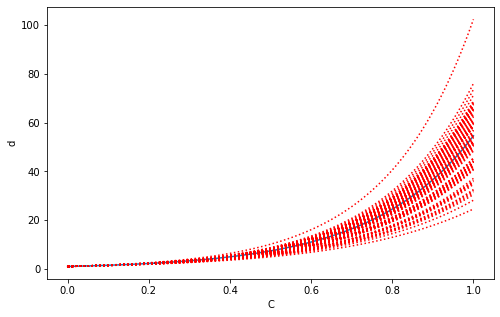

In [5]:
ax = plt.figure().gca()
ax.set(xlabel='C', ylabel='d')
ax.plot(Cgrid,mugrid)
# run the linear estimator 100 times for randomly chosen locations C
for i in range(100):
    d, C = model_1d(m, n, x)
    def f(x):
        e = d - np.exp(C @ x)
        return 0.5 * e.dot(e)
    res = minimize(f, x)
    x_est = res.x
    mu_estgrid = np.exp(Cgrid @ x_est)
    ax.plot(Cgrid, mu_estgrid, 'r:')

Now let's set up a problem like this were $C$ is a sparse matrix and $x$ is a vector.

In [9]:
m = 1000
n = 500
C = sprand(m, n, 0.1)
print(np.linalg.cond((C.T @ C).toarray()))

473.50561301254635


**Activity 1 (2 points):** Let $F(x) = \exp(C x)$ and $f(x) = \tfrac{1}{2} \|F(x) - d\|_2^2$.  If we approached the nonlinear least-squares problem as a minimization problem as we have already in the semester, we would either compute or approximate $\nabla^2 f(x)$.  Today, however, we are exploring methods that only require $\nabla F$.
Compute $J = \nabla F$ for this problem.

In [25]:
def F(x, C):
    z = C @ x
    mu = np.exp(z)
    return mu

def J(x, C):
    """Return a sparse matrix representation of the Jacobian of F"""
    mu = F(x, C)
    return diags(mu) @ C

In [26]:
# run a finite difference test to see if the Jacobian is correct
x = np.random.rand(n)
mu = F(x, C)
dmu = J(x, C)
y = np.random.randn(n)
epss = [1.e-4, 5.e-5]
rs = []
for eps in epss:
    xnew = x + eps * y
    mupred = mu + eps * dmu @ y
    munew = F(xnew, C)
    rs.append(np.linalg.norm(mupred - munew) / np.linalg.norm(munew))
print(rs)

# estimate how quickly the linear prediction is converging to the truth: should be second order
order_est = np.log2(rs[0] / rs[1]) / np.log2(epss[0] / epss[1])
print(order_est)
assert(order_est > 1.9)

[8.73499702091647e-07, 2.1833252356118526e-07]
2.0002801559727335


In [23]:
# run a finite difference test to see if the Jacobian is correct
x = np.random.rand(n)
mu = F(x, C)
dmu = J(x, C)
y = np.random.randn(n)
epss = [1.e-4, 5.e-5]
rs = []
for eps in epss:
    xnew = x + eps * y
    mupred = mu + eps * dmu @ y
    munew = F(xnew, C)
    rs.append(np.linalg.norm(mupred - munew) / np.linalg.norm(munew))

# estimate how quickly the linear prediction is converging to the truth: should be second order
order_est = np.log2(rs[0] / rs[1]) / np.log2(epss[0] / epss[1])
print(order_est)
assert(order_est > 1.9)

0.999845899306317


AssertionError: 

## Gauss-Newton

The gradient $\nabla f(x)$ is

$$\nabla f(x) = (F(x) - d)^T J(x).$$

The action of the true Hessian $\nabla^2 f(x)[v]$ is

$$\nabla^2 f(x)[v] = J^T(x) J(x) v + (F(x) - d)^T \nabla J(x)[v].$$

You can see that if $F(x) - d = 0$, then

$$\nabla^2 f(x)[v] = J^T(x) J(x) v.$$

The linear operator $J^T(x) J(x)$ is the _Gauss-Newton approximation_ to the Hessian $\nabla^2 f(x)$.

Therefore if there is a value of $x^*$ such that $d = F(x^*)$, then the Gauss-Newton approximation to the Hessian
_is_ the Hessian at the solution to the nonlinear least-squares problem.

We set up the necessary routines for evaluating $f$, $\nabla f$, and the Gauss-Newton Hessian approximation.

In [27]:
class GaussNewton(LinearOperator):
    def __init__(self, x, C):
        super(GaussNewton,self).__init__(shape=(C.shape[1],)*2, dtype=C.dtype)
        self._GNJ = J(x, C)
        
    def _matvec(self, v):
        return self._GNJ.T @ (self._GNJ @ v)

def f(x, d, C):
    e = F(x,C) - d
    return 0.5 * e.dot(e)

def f_grad(x, d, C):
    Jx = J(x,C)
    e = F(x,C) - d
    return Jx.T @ e

def f_hess_gauss_newton(x, d, C):
    return GaussNewton(x, C)

Now we define a standard Newton-CG iteration (note: the Gauss-Newton Hessian is always symmetric positive semi-definite, so we can use CG without the Steihaug termination condition).

In [28]:
def newton_cg(f, f_grad, f_hess, x0, args=(), maxiter=100, gtol=1.e-6, xtol=1.e-12, armijo=1.e-4, lamda_min=1.e-12, verbose=False):
    x = x0.copy()
    fx = f(x, *args)
    gx = f_grad(x, *args)
    gxnorm = np.linalg.norm(gx)
    rs = []
    rs.append(gxnorm)
    for i in range(maxiter):
        if gxnorm < gtol:
            return x, rs
        H = f_hess(x, *args)
        p = cg(H, -gx, tol=1.e-12)
        p = p[0]
        phi_grad = p.dot(gx)
        assert(phi_grad < 0.)
        lamda = 1.
        while lamda >= lamda_min:
            xnew = x + lamda * p
            fxnew = f(xnew, *args)
            diff = fxnew - fx
            if diff < armijo * lamda * phi_grad:
                break
            lamda *= 0.5
        if np.linalg.norm(lamda*p) < xtol:
            return x, rs
        fx = fxnew
        x = xnew
        gx = f_grad(x, *args)
        if verbose:
            print(lamda, gx.dot(p) / phi_grad)
        gxnorm = np.linalg.norm(gx)
        rs.append(gxnorm)
    return x, np.array(rs)

First we observe what the convergence is like when the vector $d_{true}$ was generated by some $x_{true}$:

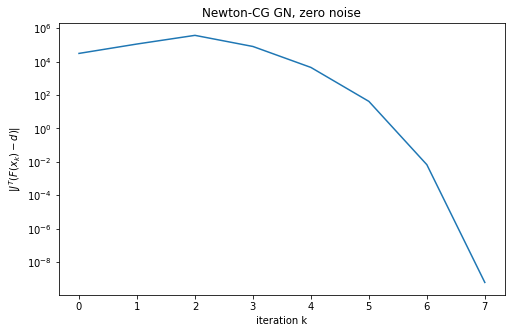

In [30]:
xtrue = 0.25 * np.random.rand(n)
dtrue = F(xtrue, C)
x, rs = newton_cg(f, f_grad, f_hess_gauss_newton, np.zeros(n), args=(dtrue, C))

ax = plt.figure().gca()
ax.set(title="Newton-CG GN, zero noise", xlabel="iteration k", ylabel=r'$\|J^T(F(x_k) - d)\|$')
_ = ax.semilogy(rs)

**Activity 2 (2 points):** Now create a plot where $d = d_{true} \epsilon$, where $\epsilon$ is random noise with mean 1 and varying standard deviations $\sigma$.

_Hint:_ Gamma($\sigma^{-2}$, $\sigma^2$) is one such choice for the random noise.

_Hint 2:_ Use a range of $\sigma$ between 0.01 and 0.5.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()